# Partial Least Squares Regression (PLS-R) and Discriminant Analysis (PLS-DA)

This notebook demonstrates two powerful multivariate analysis techniques used in sensory science:

1. **Partial Least Squares Regression (PLS-R)**: A supervised method that finds relationships between predictor variables (X) and a continuous response variable (y). Useful for predicting continuous outcomes like quality scores.

2. **Partial Least Squares Discriminant Analysis (PLS-DA)**: A supervised classification method that finds relationships between predictor variables (X) and categorical class labels (y). Useful for classifying products into categories.

**What makes PLS special?**
- Handles multicollinearity (correlated predictors) better than ordinary regression
- Works well when you have more predictors than samples
- Finds latent variables (components) that maximize covariance between X and y
- Provides interpretable loadings showing which predictors are most important

**Learning Objectives:**
- Understand the difference between PLS-R and PLS-DA
- Perform PLS-R to predict continuous quality scores
- Perform PLS-DA to classify products into categories
- Interpret PLS loadings and coefficients
- Visualize PLS results and evaluate model performance

---

## Installation Instructions

Before running this notebook, make sure you have the required packages installed. Run the following command in your terminal or command prompt:

```bash
pip install pandas numpy scikit-learn matplotlib seaborn
```

If you are using Anaconda, you can also install using conda:
```bash
conda install pandas numpy scikit-learn matplotlib seaborn
```

---

## Data Credits

This notebook uses the Wine Quality dataset from the UCI Machine Learning Repository:

**Citation:**
Cerdeira-A. Almeida F. Matos T. Cortez, Paulo and J. Reis. Wine Quality. UCI Machine Learning Repository, 2009. DOI: https://doi.org/10.24432/C56S3T

We acknowledge and thank the authors for making this dataset publicly available for educational and research purposes.

## 1. Import Required Libraries

We will import all necessary libraries for data manipulation, machine learning, and visualization.

In [14]:
# Data manipulation and numerical operations
import pandas as pd
import numpy as np

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import (r2_score, mean_squared_error, accuracy_score, 
                            classification_report, confusion_matrix, ConfusionMatrixDisplay)

# Visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import seaborn as sns

# Custom Illinois colors for visualizations
illiniorange = "#FF5F05"
illiniblue = "#13294B"


## 2. Load and Prepare Data

We will load the wine quality dataset and prepare it for both PLS-R (regression) and PLS-DA (classification) analyses. The dataset contains physicochemical measurements and quality ratings for red wines.


In [15]:
# Load wine quality dataset
df = pd.read_csv("data/winequality-red.csv", sep=",")

# Display basic information about the dataset
print("Dataset shape:", df.shape)
print("\nColumn names:")
print(df.columns.tolist())
print("\nFirst few rows:")
print(df.head())

# Prepare predictor matrix (X) and response variables
# X contains all physicochemical variables (predictors)
X = df.drop(columns=["quality"]).values
feature_names = df.drop(columns=["quality"]).columns

# Continuous target for PLS-R (quality as a continuous variable)
y_cont = df["quality"].values.astype(float)

print(f"\nNumber of samples: {len(df)}")
print(f"Number of predictors: {len(feature_names)}")
print(f"Predictors: {list(feature_names)}")
print(f"\nQuality range: {y_cont.min()} to {y_cont.max()}")
print(f"Quality distribution:")
print(df["quality"].value_counts().sort_index())


Dataset shape: (1599, 12)

Column names:
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

First few rows:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.

## 3. Partial Least Squares Regression (PLS-R)

PLS-R finds linear combinations of predictor variables (latent components) that best explain the variation in a continuous response variable. It is particularly useful when:
- Predictors are highly correlated (multicollinearity)
- You have many predictors relative to samples
- You want to understand which predictors drive the response

**How PLS-R works:**
- Finds components that maximize covariance between X and y
- Projects both predictors and response onto these components
- Uses these components to predict the response
- Provides loadings showing which predictors contribute to each component


In [16]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cont, test_size=0.3, random_state=123
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

# Standardize predictors
# PLS-R works best with standardized variables
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)
X_test_z = scaler.transform(X_test)

# Fit PLS-R model
# Choose number of components (typically 2-5; can be tuned via cross-validation)
n_comp = 3
pls_r = PLSRegression(n_components=n_comp)
pls_r.fit(X_train_z, y_train)

# Make predictions on test set
y_pred = pls_r.predict(X_test_z).ravel()

# Evaluate model performance
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\n" + "="*60)
print("PLS-R Model Performance:")
print("="*60)
print(f"Number of components: {n_comp}")
print(f"R² score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print("\nInterpretation:")
print("- R²: Proportion of variance in quality explained by the model")
print("- RMSE: Root mean squared error (lower is better)")


Training set size: 1119 samples
Testing set size: 480 samples

PLS-R Model Performance:
Number of components: 3
R² score: 0.325
RMSE: 0.653

Interpretation:
- R²: Proportion of variance in quality explained by the model
- RMSE: Root mean squared error (lower is better)


### 3.1. Interpret PLS-R Loadings

Loadings show how much each predictor variable contributes to each PLS component. Higher absolute values indicate stronger contributions. This helps identify which physicochemical properties are most important for predicting wine quality.


In [17]:
# Extract X-weights (loadings) showing importance of predictors in each component
x_weights = pls_r.x_weights_  # Shape: n_features × n_components

# Create dataframe for easier interpretation
pls_r_loadings = pd.DataFrame(
    x_weights,
    index=feature_names,
    columns=[f"Comp{i+1}" for i in range(n_comp)]
)

print("PLS-R Loadings (X-Weights):")
print("="*60)
print("These values show how each predictor contributes to each PLS component")
print("Higher absolute values = stronger contribution to that component")
print("\n" + pls_r_loadings.round(3).to_string())


PLS-R Loadings (X-Weights):
These values show how each predictor contributes to each PLS component
Higher absolute values = stronger contribution to that component

                      Comp1  Comp2  Comp3
fixed acidity         0.115  0.384  0.318
volatile acidity     -0.506 -0.100 -0.043
citric acid           0.271  0.563 -0.231
residual sugar        0.017 -0.264  0.496
chlorides            -0.184  0.313 -0.017
free sulfur dioxide  -0.105 -0.319  0.149
total sulfur dioxide -0.248 -0.140  0.069
density              -0.241  0.230  0.481
pH                   -0.025 -0.306 -0.386
sulphates             0.320 -0.081  0.436
alcohol               0.624 -0.289 -0.013


### 3.2. Visualize PLS-R Predictions

A scatter plot of observed vs. predicted quality shows how well the model performs. Points close to the 1:1 line indicate good predictions.


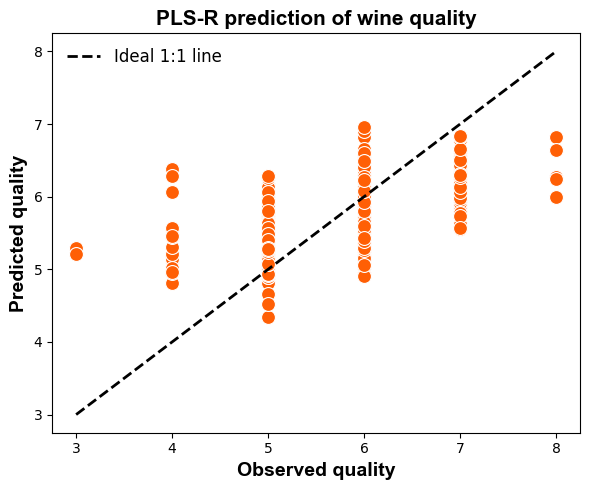

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Scatter: observed vs predicted quality
plt.figure(figsize=(6, 5))
sns.scatterplot(x=y_test, y=y_pred, color=illiniorange, s = 100)
min_q = min(y_test.min(), y_pred.min())
max_q = max(y_test.max(), y_pred.max())
plt.plot([min_q, max_q], [min_q, max_q], 'k--', lw = 2, label='Ideal 1:1 line')
plt.xlabel('Observed quality', fontsize = 14, weight = 'bold', family = 'Arial')
plt.ylabel('Predicted quality', fontsize = 14, weight = 'bold', family = 'Arial')
plt.title('PLS-R prediction of wine quality', fontsize = 15, weight = 'bold', family = 'Arial')
plt.legend(fontsize = 12, frameon = False)
plt.tight_layout()
plt.show()


# residuals = y_test - y_pred
# plt.figure(figsize=(6, 4))
# sns.scatterplot(x=y_pred, y=residuals)
# plt.axhline(0, color='r', linestyle='--')
# plt.xlabel('Predicted quality')
# plt.ylabel('Residual (observed − predicted)')
# plt.title('PLS-R residual plot')
# plt.tight_layout()
# plt.show()


## 4. Partial Least Squares Discriminant Analysis (PLS-DA)

PLS-DA is used for classification when the response variable is categorical (e.g., low vs. high quality). It works by:
1. Converting class labels to dummy variables (one-hot encoding)
2. Applying PLS regression to these dummy variables
3. Classifying samples based on predicted dummy scores

**When to use PLS-DA:**
- You have categorical outcomes (e.g., product categories, quality classes)
- Predictors are correlated or numerous
- You want to understand which predictors distinguish between classes


### 4.1. Create Categorical Quality Classes

We will convert the continuous quality scores into categorical classes (low and high) for PLS-DA classification. This allows us to use PLS-DA for classification instead of regression.

In [ ]:
# Create categorical quality classes
# Wines with quality <= 5 are "low", quality > 5 are "high"
bins = [0, 5, 10]
labels = ["low", "high"]
y_class = pd.cut(df["quality"], bins=bins, labels=labels, right=True)

print("Quality Class Distribution:")
print("="*60)
print(y_class.value_counts().sort_index())
print(f"\nTotal samples: {len(y_class)}")

Quality Class Distribution:
quality
low     744
high    855
Name: count, dtype: int64

Total samples: 1599


### 4.2. Fit PLS-DA Model

We will one-hot encode the class labels and fit a PLS model to predict these categorical classes. One-hot encoding converts categorical labels into binary dummy variables that PLS can work with.

In [25]:
# One-hot encode class labels for PLS regression
# This converts categorical labels into binary dummy variables
enc = OneHotEncoder(sparse_output=False)
Y_dummy = enc.fit_transform(y_class.to_numpy().reshape(-1, 1))
class_names = enc.categories_[0]

print(f"Class names: {class_names}")
print(f"Dummy variable shape: {Y_dummy.shape}")

# Train/test split (same X predictors, but with dummy class labels)
# stratify ensures proportional representation of classes in both sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y_dummy, test_size=0.3, random_state=123, stratify=y_class
)

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

# Standardize predictors
scaler_da = StandardScaler()
X_train_z = scaler_da.fit_transform(X_train)
X_test_z = scaler_da.transform(X_test)

# Fit PLS-DA model
n_comp_da = 3
pls_da = PLSRegression(n_components=n_comp_da)
pls_da.fit(X_train_z, Y_train)

# Predict dummy responses (probabilities for each class)
Y_pred = pls_da.predict(X_test_z)

# Convert predicted dummy scores to class labels
# The class with the highest predicted score is the predicted class
y_pred_class = class_names[np.argmax(Y_pred, axis=1)]
y_true_class = class_names[np.argmax(Y_test, axis=1)]

# Evaluate classification performance
accuracy = accuracy_score(y_true_class, y_pred_class)

print("\n" + "="*60)
print("PLS-DA Model Performance:")
print("="*60)
print(f"Number of components: {n_comp_da}")
print(f"Accuracy: {accuracy:.3f}")
print("\nDetailed Classification Report:")
print(classification_report(y_true_class, y_pred_class, target_names=class_names))


Class names: ['high' 'low']
Dummy variable shape: (1599, 2)

Training set size: 1119 samples
Testing set size: 480 samples

PLS-DA Model Performance:
Number of components: 3
Accuracy: 0.746

Detailed Classification Report:
              precision    recall  f1-score   support

        high       0.78      0.74      0.76       257
         low       0.71      0.76      0.73       223

    accuracy                           0.75       480
   macro avg       0.75      0.75      0.75       480
weighted avg       0.75      0.75      0.75       480



### 4.3. Visualize Confusion Matrix

A confusion matrix shows how many samples were correctly classified and how many were misclassified. This helps identify which classes are easier to distinguish.


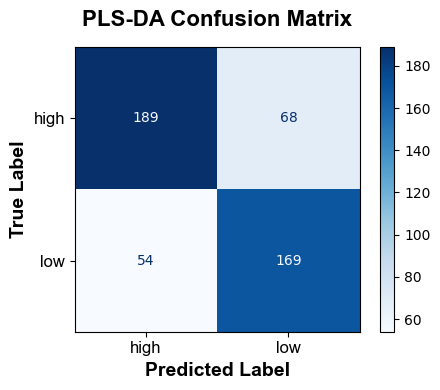


Confusion Matrix Interpretation:
- Diagonal values = correct classifications
- Off-diagonal values = misclassifications
- Total correct: 358 out of 480


In [27]:
# Create and display confusion matrix
cm = confusion_matrix(y_true_class, y_pred_class, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(5, 4))
disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format='d')

plt.title('PLS-DA Confusion Matrix', 
          fontsize=16, weight='bold', family='Arial', pad=15)
plt.xlabel('Predicted Label', fontsize=14, weight='bold', family='Arial')
plt.ylabel('True Label', fontsize=14, weight='bold', family='Arial')
plt.xticks(fontsize=12, family='Arial')
plt.yticks(fontsize=12, family='Arial')
plt.tight_layout()
plt.show()

print("\nConfusion Matrix Interpretation:")
print("="*60)
print("- Diagonal values = correct classifications")
print("- Off-diagonal values = misclassifications")
print(f"- Total correct: {np.trace(cm)} out of {cm.sum()}")


### 4.4. Interpret PLS-DA Loadings

Loadings show which predictor variables contribute most to each PLS component in the classification model. This helps identify which physicochemical properties are most important for distinguishing between quality classes.


In [28]:
# Extract X-weights (loadings) for PLS-DA
x_weights_da = pls_da.x_weights_

# Create dataframe for easier interpretation
pls_da_loadings = pd.DataFrame(
    x_weights_da,
    index=feature_names,
    columns=[f"Comp{i+1}" for i in range(n_comp_da)]
)

print("PLS-DA Loadings (X-Weights):")
print("="*60)
print("These values show how each predictor contributes to each PLS component")
print("Higher absolute values = stronger contribution to that component")
print("\n" + pls_da_loadings.round(3).to_string())


PLS-DA Loadings (X-Weights):
These values show how each predictor contributes to each PLS component
Higher absolute values = stronger contribution to that component

                      Comp1  Comp2  Comp3
fixed acidity         0.112 -0.158  0.506
volatile acidity     -0.496  0.016 -0.120
citric acid           0.206 -0.609 -0.115
residual sugar       -0.037  0.235  0.109
chlorides            -0.175 -0.211  0.123
free sulfur dioxide  -0.097  0.623  0.145
total sulfur dioxide -0.353  0.007 -0.294
density              -0.262 -0.026  0.509
pH                   -0.016  0.183 -0.461
sulphates             0.314  0.214  0.271
alcohol               0.605  0.191 -0.191


### 4.5. Visualize PLS-DA Scores

Scores plots show where samples are positioned in PLS component space. We will create two visualizations:
1. Samples colored by their true class (showing class separation)
2. Samples colored by classification result (correct vs. misclassified)


/var/folders/cx/_v080m5s5757ktxy0dsp15tr0000gn/T/ipykernel_18698/3098570161.py:100: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


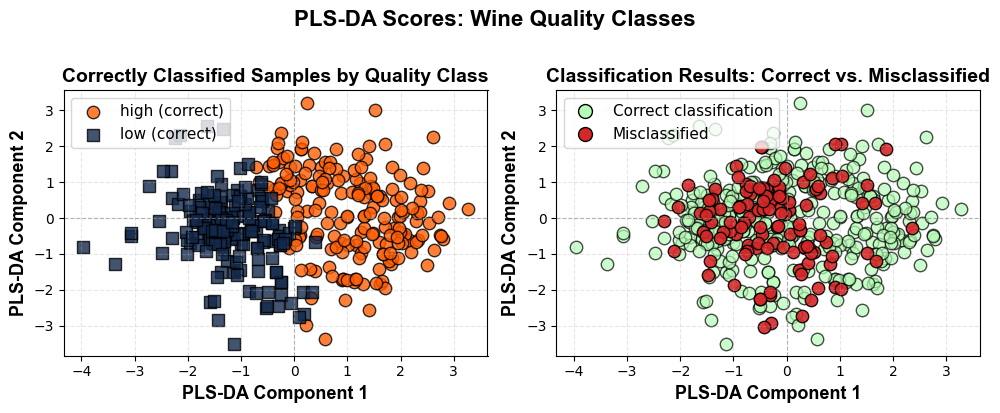

In [31]:
# Calculate PLS-DA scores for test samples
scores_da = pls_da.transform(X_test_z)  # Shape: n_samples × n_components
pc1 = scores_da[:, 0]
pc2 = scores_da[:, 1]

# Create figure with two subplots
fig = plt.figure(constrained_layout=True, figsize=(10, 4))
gs = gridspec.GridSpec(1, 2, figure=fig)

# Find axis limits for both plots (keep them consistent)
x_min, x_max = np.min(pc1), np.max(pc1)
y_min, y_max = np.min(pc2), np.max(pc2)
pad_x = (x_max - x_min) * 0.05 if (x_max - x_min) != 0 else 1
pad_y = (y_max - y_min) * 0.05 if (y_max - y_min) != 0 else 1
xlim = (x_min - pad_x, x_max + pad_x)
ylim = (y_min - pad_y, y_max + pad_y)

# --- First plot: Correctly classified samples, colored by class
ax1 = fig.add_subplot(gs[0, 0])
class_color_map = {"low": illiniblue, "high": illiniorange}

for i, cls in enumerate(class_names):
    correct = (y_true_class == cls) & (y_true_class == y_pred_class)
    color = class_color_map.get(cls, plt.rcParams['axes.prop_cycle'].by_key()['color'][i % 10])
    marker = "s" if cls == "low" else "o" if cls == "high" else "D"
    ax1.scatter(
        pc1[correct], pc2[correct],
        label=f"{cls} (correct)",
        alpha=0.8,
        color=color,
        marker=marker,
        edgecolor='k', 
        s=80
    )

ax1.axhline(0, color='grey', linewidth=0.8, linestyle='--', alpha=0.5)
ax1.axvline(0, color='grey', linewidth=0.8, linestyle='--', alpha=0.5)
ax1.set_xlabel('PLS-DA Component 1', fontsize=13, weight='bold', family='Arial')
ax1.set_ylabel('PLS-DA Component 2', fontsize=13, weight='bold', family='Arial')
ax1.set_title('Correctly Classified Samples by Quality Class', 
              fontsize=14, weight='bold', family='Arial')
ax1.legend(loc='upper left', fontsize=11, frameon=True)
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax1.grid(True, alpha=0.3, linestyle='--')

# --- Second plot: Correct vs. misclassified
ax2 = fig.add_subplot(gs[0, 1])

good_color = "#b6fcb6"  # Pale green for correct
bad_color = "tab:red"   # Red for misclassified

# Plot correctly classified samples
correct_mask = y_true_class == y_pred_class
ax2.scatter(
    pc1[correct_mask], pc2[correct_mask],
    c=good_color,
    label="Correct classification",
    edgecolor="k",
    marker="o",
    s=80,
    alpha=0.7,
    linewidths=1
)

# Plot misclassified samples
misclassified_mask = y_true_class != y_pred_class
ax2.scatter(
    pc1[misclassified_mask], pc2[misclassified_mask],
    c=bad_color,
    label="Misclassified",
    edgecolor="k",
    marker="o",
    s=80,
    alpha=0.9,
    linewidths=1
)

ax2.axhline(0, color='grey', linewidth=0.8, linestyle='--', alpha=0.5)
ax2.axvline(0, color='grey', linewidth=0.8, linestyle='--', alpha=0.5)
ax2.set_xlabel('PLS-DA Component 1', fontsize=13, weight='bold', family='Arial')
ax2.set_ylabel('PLS-DA Component 2', fontsize=13, weight='bold', family='Arial')
ax2.set_title('Classification Results: Correct vs. Misclassified', 
              fontsize=14, weight='bold', family='Arial')
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.grid(True, alpha=0.3, linestyle='--')

# Custom legend for right plot
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Correct classification', 
           markerfacecolor=good_color, markeredgecolor='k', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Misclassified', 
           markerfacecolor=bad_color, markeredgecolor='k', markersize=10),
]
ax2.legend(handles=legend_elements, loc='upper left', fontsize=11, frameon=True)

plt.suptitle('PLS-DA Scores: Wine Quality Classes', 
             fontsize=16, weight='bold', family='Arial', y=1.02)
plt.tight_layout()
plt.show()


### 4.6. Visualize PLS-DA Coefficients

Coefficients show how each predictor variable contributes to predicting each class. Positive coefficients indicate the predictor increases the probability of that class, while negative coefficients indicate it decreases the probability.


PLS-DA Coefficients:
These values show how each predictor contributes to predicting each class
Positive values = predictor increases probability of that class
Negative values = predictor decreases probability of that class

                       high    low
fixed acidity         0.032 -0.032
volatile acidity     -0.109  0.109
citric acid          -0.020  0.020
residual sugar        0.020 -0.020
chlorides            -0.051  0.051
free sulfur dioxide   0.046 -0.046
total sulfur dioxide -0.088  0.088
density              -0.034  0.034
pH                   -0.008  0.008
sulphates             0.100 -0.100
alcohol               0.138 -0.138


<Figure size 1200x600 with 0 Axes>

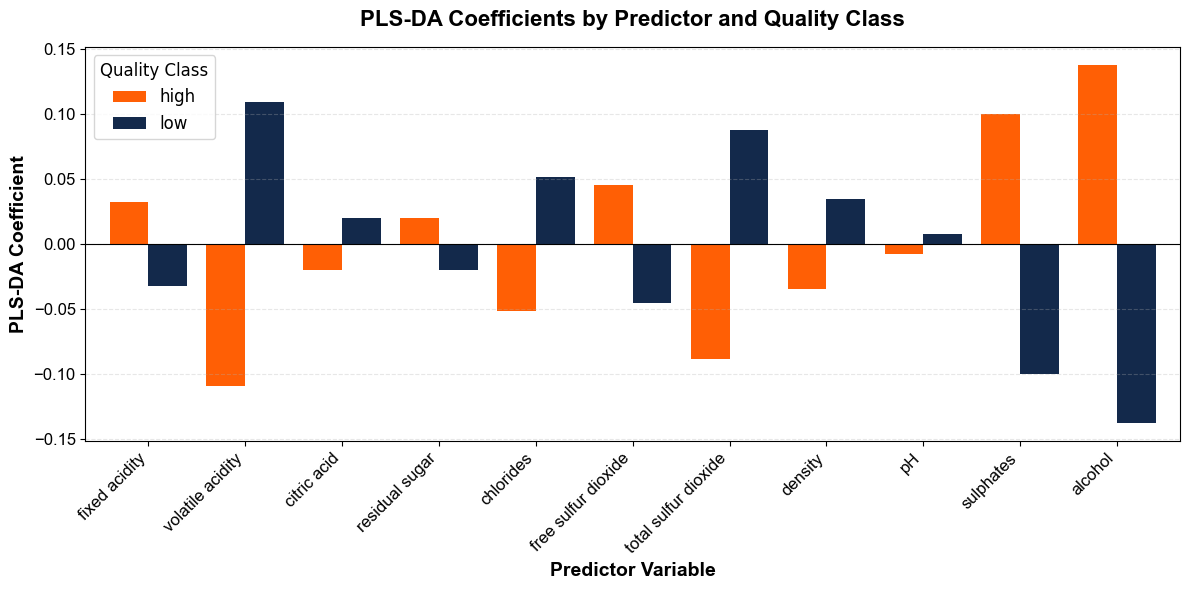

In [32]:
# Extract PLS-DA coefficients
coef_da = pls_da.coef_  # Shape: n_features × n_classes or n_classes × n_features

# Check and transpose if needed to ensure shape compatibility
if coef_da.shape == (len(class_names), len(feature_names)):
    coef_da = coef_da.T

# Create dataframe for easier interpretation
coef_df = pd.DataFrame(coef_da, index=feature_names, columns=class_names)

print("PLS-DA Coefficients:")
print("="*60)
print("These values show how each predictor contributes to predicting each class")
print("Positive values = predictor increases probability of that class")
print("Negative values = predictor decreases probability of that class")
print("\n" + coef_df.round(3).to_string())

# Create bar plot of coefficients
uiuc_colors = [illiniorange, illiniblue]
color_cycle = uiuc_colors * (len(class_names) // len(uiuc_colors) + 1)

plt.figure(figsize=(12, 6))
ax = coef_df.plot(kind='bar', figsize=(12, 6), color=color_cycle[:len(class_names)], width=0.8)
plt.ylabel('PLS-DA Coefficient', fontsize=14, weight='bold', family='Arial')
plt.xlabel('Predictor Variable', fontsize=14, weight='bold', family='Arial')
plt.title('PLS-DA Coefficients by Predictor and Quality Class', 
          fontsize=16, weight='bold', family='Arial', pad=15)
plt.xticks(rotation=45, ha='right', fontsize=12, family='Arial')
plt.yticks(fontsize=12, family='Arial')
plt.axhline(0, color='black', linewidth=0.8, linestyle='-')
plt.legend(title="Quality Class", fontsize=12, title_fontsize=12, frameon=True)
plt.grid(True, alpha=0.3, axis='y', linestyle='--')
plt.tight_layout()
plt.show()
